In [38]:
import torch

import numpy as np

from sbi.analysis import pairplot
from sbi.inference import NPE,NLE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from torch.distributions import Normal, Independent

In [39]:
num_dim = 1  # 这里的 num_dim = 2，表示我们有两个参数 μ 和 σ

# 定义模拟器函数
# torch.randn：生成一个服从标准正态分布（即均值为 0，标准差为 1）的随机数。
def simulator(theta, n=1000):
    # theta[0] 是 μ, theta[1] 是 σ
    mu, sigma2 = theta[0], 1
    sigma = np.sqrt(sigma2)
    return mu + sigma * torch.randn(n)  # 生成 n 组观测数据


#torch.ones(num_dim)是参数的维度

# prior = BoxUniform(low= -2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
#必须是torch.distributions 因为需要sample
prior = Normal(torch.tensor([0.0]), torch.tensor([1.0]))


In [40]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [41]:
inference = NPE(prior=prior)
# 生成模拟数据
num_simulations = 500
theta = prior.sample((num_simulations,))
x = simulator(theta)

# 打印检查
print("theta.shape", theta.shape)
print("x.shape", x.shape)

theta.shape torch.Size([500, 1])
x.shape torch.Size([500, 1000])


In [42]:
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

 Training neural network. Epochs trained: 6

/opt/anaconda3/envs/SBI_project/lib/python3.11/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 39 epochs.

In [43]:
posterior = inference.build_posterior(density_estimator)

In [44]:
# # 手动设置 theta 的真实值
theta_true = torch.tensor([[0]])  # μ = 0.0
x_obs = simulator(theta_true)
samples = posterior.sample((10000,), x=x_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [45]:
# pairplot(samples,
#          points=theta_true,
#          limits=[[-3, 3]], figsize=(6, 6),
#          labels=[r"$mu$"]); 
# 
# #：感觉似乎有点关联性

In [46]:
import numpy as np

# 先验参数
mu_0 = 0
sigma_0_sq = 1  # 先验方差

# 数据准备
Z = x_obs.numpy()  # 如果是 PyTorch 张量，转换为 NumPy 数组
Z_flat = Z.flatten()  # 展平成一维数组

# 样本均值和样本数量
Y_mean = np.mean(Z_flat)  # 样本均值
n = Z.size  # 样本数量

# 后验均值 μ'
mu_post = (mu_0 + n * Y_mean) / (1 + n)

# 后验方差 σ_post^2
sigma_post_sq = sigma_0_sq / (1 + n)

# 输出结果
print("Posterior Mean (mu_post):", mu_post)
print("Posterior Variance (sigma_post_sq):", sigma_post_sq)


Posterior Mean (mu_post): 0.021003337426261825
Posterior Variance (sigma_post_sq): 0.000999000999000999


In [47]:
# import numpy as np
# import matplotlib.pyplot as plt
# 
# # 示例参数
# 
# 
# # 计算标准差
# sigma_post = np.sqrt(sigma_post_sq)
# 
# # 生成 x 轴范围（手动指定范围）
# x = np.linspace(mu_post - 6 * sigma_post, mu_post + 6 * sigma_post, 500)
# 
# sigma_post_sq = 1  # 方差
# mu_post = 0        # 均值
# # 计算正态分布的概率密度函数
# pdf = (1 / (np.sqrt(2 * np.pi) * sigma_post)) * np.exp(-0.5 * ((x - mu_post) / sigma_post) ** 2)
# 
# # 绘图
# plt.figure(figsize=(10, 10))
# plt.plot(x, pdf, label=f"Normal Distribution\n$\mu={mu_post}$, $\sigma^2={sigma_post_sq}$")
# 
# # 调整绘图范围
# plt.xlim(mu_post - 6 * sigma_post, mu_post + 6 * sigma_post)
# plt.ylim(0, max(pdf) * 1.2)  # 让 y 轴稍微高出最大值
# plt.title("Normal Distribution")
# plt.xlabel("x")
# plt.ylabel("Probability Density")
# plt.legend()
# plt.grid(True)
# plt.show()


In [48]:
# import seaborn as sns
# # pairplot 数据准备
# mu_samples = samples[:, 0].numpy()  # 提取样本的第一个维度（例如 $\mu$）
# theta_true = theta_true.numpy() if torch.is_tensor(theta_true) else theta_true
# 
# # 创建单个绘图
# fig, ax = plt.subplots(figsize=(8, 6))
# 
# # 绘制 Posterior Samples 的 KDE 图
# sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$")
# 
# sigma_post_sq = 0.0010600414062659155 # 方差
# mu_post = -0.015340934743400475        # 均值
# # 计算正态分布的概率密度函数
# pdf = (1 / (np.sqrt(2 * np.pi) * sigma_post)) * np.exp(-0.5 * ((x - mu_post) / sigma_post) ** 2)
# 
# # 绘制正态分布
# ax.plot(x, pdf, label=f"Real Posterior Distribution\n$\mu={mu_post}$, $\sigma^2={sigma_post_sq}$", color="red", linestyle="--")
# 
# sigma_post_sq = 1  # 方差
# mu_post = 0        # 均值
# # 计算正态分布的概率密度函数
# pdf1 = (1 / (np.sqrt(2 * np.pi) * sigma_post)) * np.exp(-0.5 * ((x - 0) / sigma_post) ** 2)
# plt.plot(x, pdf1, label=f"Prior Distribution\n$\mu={0}$, $\sigma^2={1}$",color="grey")
# 
# # 添加图例、标题和标签
# ax.set_title("Gaussian Approximation VS SBI on miu = 0")
# ax.set_xlabel(r"$\mu$")
# ax.set_ylabel("Density")
# ax.legend()
# ax.grid(True)
# 
# # 显示图形
# plt.tight_layout()
# plt.show()


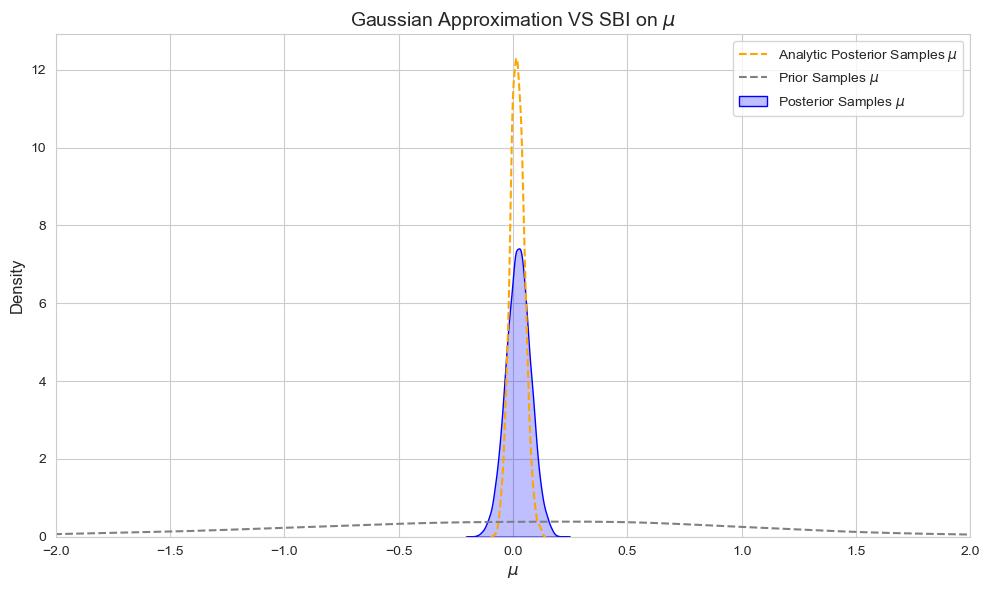

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 mu_post 和 sigma_post_sq 已经定义
sigma_post = np.sqrt(sigma_post_sq)    # Posterior 标准差
sigma_prior_sq = 1
mu_prior = 0
sigma_prior = np.sqrt(sigma_prior_sq)

# 从 Posterior 分布中生成样本
num_samples = 1000  # 样本数量
mu_samples = np.random.normal(loc=mu_post, scale=sigma_post, size=num_samples)

# 从 Prior 分布中生成样本
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 使用样本绘制 KDE 图
sns.kdeplot(mu_samples, ax=ax, label=r"Analytic Posterior Samples $\mu$", color="orange", linestyle="--")

# 使用样本绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, label=r"Prior Samples $\mu$", color="grey", linestyle="--")

mu_samples = samples[:, 0].numpy()  # 提取样本的第一个维度（例如 $\mu$）
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# 添加图例、标题和标签
ax.set_title("Gaussian Approximation VS SBI on $\mu$", fontsize=14)
ax.set_xlabel(r"$\mu$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(-2, 2)

# 显示图形
plt.tight_layout()
plt.show()


In [50]:
# # 手动设置 theta 的真实值
theta_true = torch.tensor([[0.3]])  # μ = 1.0
x_obs = simulator(theta_true)
samples = posterior.sample((10000,), x=x_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [51]:
import numpy as np

# 先验参数
mu_0 = 0
sigma_0_sq = 1  # 先验方差

# 数据准备
Z = x_obs.numpy()  # 如果是 PyTorch 张量，转换为 NumPy 数组
Z_flat = Z.flatten()  # 展平成一维数组

# 样本均值和样本数量
Y_mean = np.mean(Z_flat)  # 样本均值
n = Z.size  # 样本数量

# 后验均值 μ'
mu_post = (mu_0 + n * Y_mean) / (1 + n)

# 后验方差 σ_post^2
sigma_post_sq = sigma_0_sq / (1 + n)

# 输出结果
print("Posterior Mean (mu_post):", mu_post)
print("Posterior Variance (sigma_post_sq):", sigma_post_sq)


Posterior Mean (mu_post): 0.32634090829443385
Posterior Variance (sigma_post_sq): 0.000999000999000999


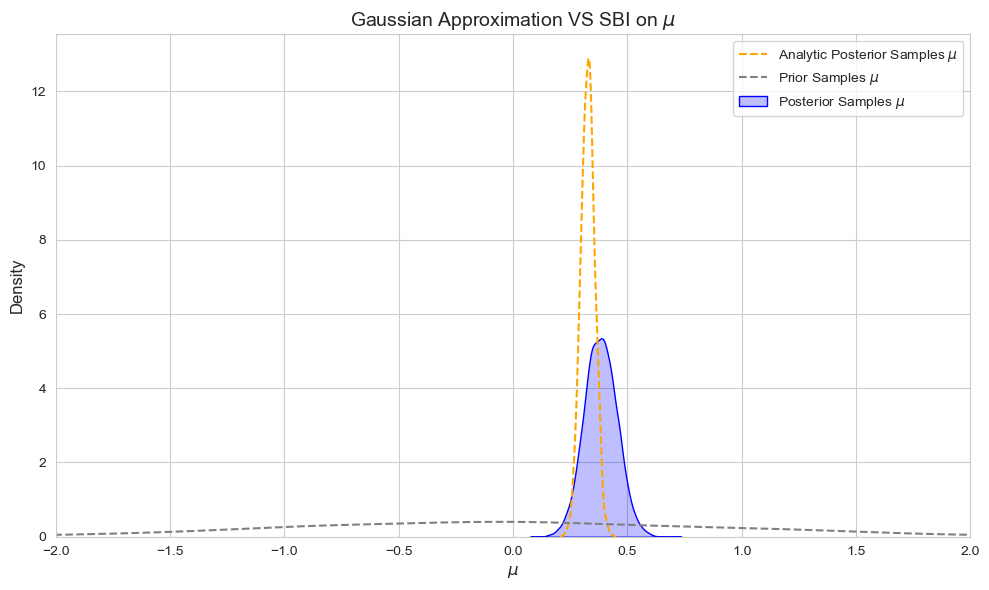

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 mu_post 和 sigma_post_sq 已经定义
sigma_post = np.sqrt(sigma_post_sq)    # Posterior 标准差
sigma_prior_sq = 1
mu_prior = 0
sigma_prior = np.sqrt(sigma_prior_sq)

# 从 Posterior 分布中生成样本
num_samples = 1000  # 样本数量
mu_samples = np.random.normal(loc=mu_post, scale=sigma_post, size=num_samples)

# 从 Prior 分布中生成样本
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 使用样本绘制 KDE 图
sns.kdeplot(mu_samples, ax=ax, label=r"Analytic Posterior Samples $\mu$", color="orange", linestyle="--")

# 使用样本绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, label=r"Prior Samples $\mu$", color="grey", linestyle="--")

mu_samples = samples[:, 0].numpy()  # 提取样本的第一个维度（例如 $\mu$）
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# 添加图例、标题和标签
ax.set_title("Gaussian Approximation VS SBI on $\mu$", fontsize=14)
ax.set_xlabel(r"$\mu$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(-2, 2)

# 显示图形
plt.tight_layout()
plt.show()


In [53]:
# # 手动设置 theta 的真实值
theta_true = torch.tensor([[-1]])  # μ = 1.0
x_obs = simulator(theta_true)
samples = posterior.sample((10000,), x=x_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [54]:
import numpy as np

# 先验参数
mu_0 = 0
sigma_0_sq = 1  # 先验方差

# 数据准备
Z = x_obs.numpy()  # 如果是 PyTorch 张量，转换为 NumPy 数组
Z_flat = Z.flatten()  # 展平成一维数组

# 样本均值和样本数量
Y_mean = np.mean(Z_flat)  # 样本均值
n = Z.size  # 样本数量

# 后验均值 μ'
mu_post = (mu_0 + n * Y_mean) / (1 + n)

# 后验方差 σ_post^2
sigma_post_sq = sigma_0_sq / (1 + n)

# 输出结果
print("Posterior Mean (mu_post):", mu_post)
print("Posterior Variance (sigma_post_sq):", sigma_post_sq)


Posterior Mean (mu_post): -0.9869274559554521
Posterior Variance (sigma_post_sq): 0.000999000999000999


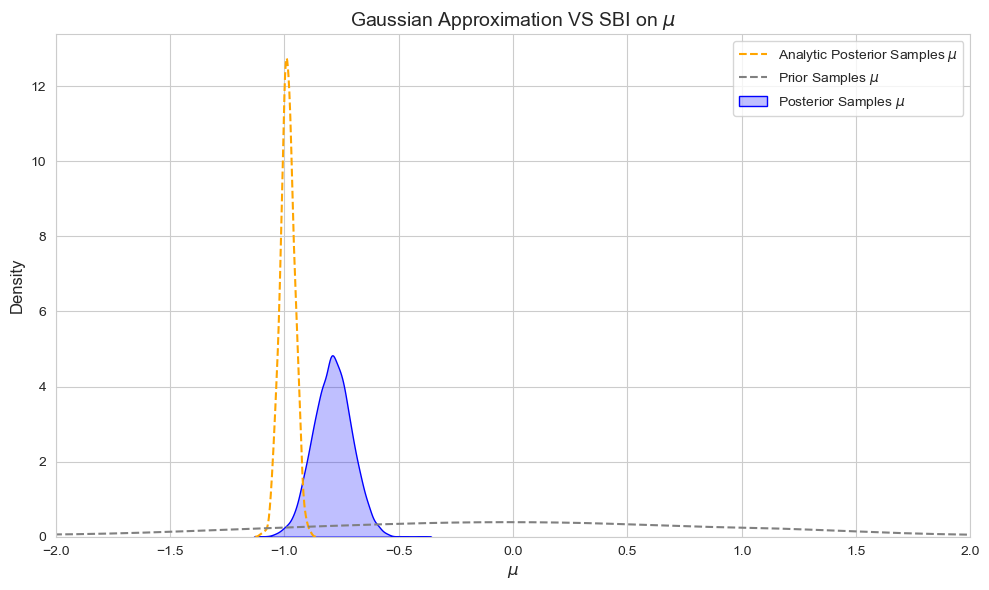

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 mu_post 和 sigma_post_sq 已经定义
sigma_post = np.sqrt(sigma_post_sq)    # Posterior 标准差
sigma_prior_sq = 1
mu_prior = 0
sigma_prior = np.sqrt(sigma_prior_sq)

# 从 Posterior 分布中生成样本
num_samples = 1000  # 样本数量
mu_samples = np.random.normal(loc=mu_post, scale=sigma_post, size=num_samples)

# 从 Prior 分布中生成样本
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 使用样本绘制 KDE 图
sns.kdeplot(mu_samples, ax=ax, label=r"Analytic Posterior Samples $\mu$", color="orange", linestyle="--")

# 使用样本绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, label=r"Prior Samples $\mu$", color="grey", linestyle="--")

mu_samples = samples[:, 0].numpy()  # 提取样本的第一个维度（例如 $\mu$）
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# 添加图例、标题和标签
ax.set_title("Gaussian Approximation VS SBI on $\mu$", fontsize=14)
ax.set_xlabel(r"$\mu$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(-2, 2)

# 显示图形
plt.tight_layout()
plt.show()
